# Adversarial Discriminative Domain Adaptation for Gaussian Domains
Adaptation of this [paper](https://arxiv.org/pdf/1702.05464.pdf) for inverting a shift between two normally distributed datasets.
The tensorflow code is inspired by [this implementation of a GAN](https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [3]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the datasets

### Source domain

In [4]:
N_source = 100

In [5]:
mean = [-1, 1]

std = 0.1
cov = np.eye(2) * std

In [6]:
x, y = np.random.multivariate_normal(mean, cov, N_source).T
X_source = np.concatenate([x.reshape(len(x), 1), y.reshape(len(y), 1)], axis=1)

### Target domain

In [7]:
N_target = 100

In [8]:
mean = [1, 1]

std = 0.1
cov = np.eye(2) * std

In [9]:
x, y = np.random.multivariate_normal(mean, cov, N_target).T
X_target = np.concatenate([x.reshape(len(x), 1), y.reshape(len(y), 1)], axis=1)

### Display the dataset

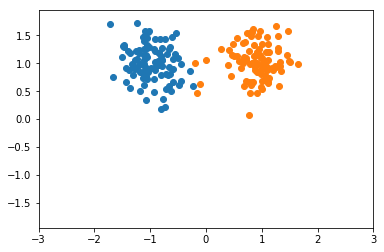

In [10]:
plt.axis("equal")
plt.axis([-3,3,-3,3])

plt.scatter(X_source[:,0], X_source[:,1])
plt.scatter(X_target[:,0], X_target[:,1])

## Create the model

### Placeholders

In [11]:
S_input = tf.placeholder(tf.float32, shape=[None, 2], name='X_source')
T_input = tf.placeholder(tf.float32, shape=[None, 2], name='X_target')

### Discriminator Network

In [12]:
D_W1 = tf.get_variable('D_W1', initializer=np.eye(2, dtype="float32"))
D_b1 = tf.get_variable('D_b1', shape=[2], initializer=tf.zeros_initializer())

D_W2 = tf.get_variable('D_W2', shape=[2, 10], initializer=tf.random_normal_initializer())
D_b2 = tf.get_variable('D_b2', shape=[10], initializer=tf.random_normal_initializer())

D_W3 = tf.get_variable('D_W3', shape=[10, 1], initializer=tf.random_normal_initializer())
D_b3 = tf.get_variable('D_b3', shape=[1], initializer=tf.random_normal_initializer())

In [13]:
theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

In [14]:
def discriminator_nn(x):  
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.sigmoid(D_logit)
    
    return D_prob, D_logit

### Target Network

In [15]:
T_W1 = tf.get_variable('T_W1', initializer=tf.eye(2, dtype="float32"))
T_b1 = tf.get_variable('T_b1', shape=[2], initializer=tf.zeros_initializer())

In [16]:
theta_T = [T_W1, T_b1]

In [17]:
def target_nn(x):  
    T_output = tf.matmul(x, T_W1) + T_b1
    
    return T_output

### Losses and solver

In [18]:
T_output = target_nn(T_input)
D_source, D_logit_source = discriminator_nn(S_input)
D_target, D_logit_target = discriminator_nn(T_output)

In [19]:
D_loss = -tf.reduce_mean(tf.log(D_source) + tf.log(1. - D_target))
T_loss = -tf.reduce_mean(tf.log(D_target))

In [20]:
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
T_solver = tf.train.AdamOptimizer().minimize(T_loss, var_list=theta_T)

In [141]:
from tensorflow.python.ops.losses import losses
from tensorflow.python.ops.losses import util
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops

def wasserstein_generator_loss(discriminator_gen_outputs,
                               weights=1.0,
                               scope=None,
                               loss_collection=ops.GraphKeys.LOSSES,
                               reduction=losses.Reduction.SUM_BY_NONZERO_WEIGHTS):

    with ops.name_scope(scope, 'generator_wasserstein_loss', (discriminator_gen_outputs, weights)) as scope:
        discriminator_gen_outputs = math_ops.to_float(discriminator_gen_outputs)

        loss = - discriminator_gen_outputs
        loss = losses.compute_weighted_loss(loss, weights, scope, loss_collection, reduction)

    return loss


def wasserstein_discriminator_loss(discriminator_real_outputs,
                                   discriminator_gen_outputs,
                                   real_weights=1.0,
                                   generated_weights=1.0,
                                   scope=None,
                                   loss_collection=ops.GraphKeys.LOSSES,
                                   reduction=losses.Reduction.SUM_BY_NONZERO_WEIGHTS):
  
    with ops.name_scope(scope, 'discriminator_wasserstein_loss', (
    discriminator_real_outputs, discriminator_gen_outputs, real_weights, generated_weights)) as scope:
        discriminator_real_outputs = math_ops.to_float(discriminator_real_outputs)
        discriminator_gen_outputs = math_ops.to_float(discriminator_gen_outputs)
        discriminator_real_outputs.shape.assert_is_compatible_with(discriminator_gen_outputs.shape)

        loss_on_generated = losses.compute_weighted_loss(
            discriminator_gen_outputs, generated_weights, scope,
            loss_collection=None, reduction=reduction)
                                            
        loss_on_real = losses.compute_weighted_loss(
            discriminator_real_outputs, real_weights, scope, loss_collection=None,
            reduction=reduction)
                                            
        loss = loss_on_generated - loss_on_real
                                            
        util.add_loss(loss, loss_collection)

    return loss

In [142]:
D_loss = wasserstein_discriminator_loss(D_source, D_target)
T_loss = wasserstein_generator_loss(D_target)

## Execute the model

In [22]:
sess = tf.InteractiveSession()

In [23]:
sess.run(tf.global_variables_initializer())
D_loss_list = []
T_loss_list = []

In [34]:
nb_iter = 200
nb_iter_d = 100
nb_samples = 10
T_loss_curr = 0.001
D_loss_curr = 0.001

for i in range(nb_iter):
    for k in range(nb_iter_d):
        sample_source = X_source[np.random.choice(len(X_source), nb_samples)]
        sample_target = X_target[np.random.choice(len(X_target), nb_samples)]
        _, D_loss_curr = sess.run([D_solver, D_loss],feed_dict={S_input: sample_source, T_input: sample_target})
    
    
    sample_target = X_target[np.random.choice(len(X_target), 10*nb_samples)]
    _, T_loss_curr = sess.run([T_solver, T_loss], feed_dict={T_input: sample_target})
    
    D_loss_list.append(D_loss_curr)
    T_loss_list.append(T_loss_curr)
    if i % (nb_iter//10) == 0:
        print('Iter: {}'.format(i))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('T_loss: {:.4}'.format(T_loss_curr))
        print()

Iter: 0
D loss: 0.7074
T_loss: 1.35

Iter: 20
D loss: 1.008
T_loss: 1.23

Iter: 40
D loss: 0.9309
T_loss: 1.214

Iter: 60
D loss: 0.8426
T_loss: 1.257

Iter: 80
D loss: 0.7654
T_loss: 1.263

Iter: 100
D loss: 1.065
T_loss: 1.176

Iter: 120
D loss: 0.9823
T_loss: 1.084

Iter: 140
D loss: 0.7123
T_loss: 0.9995

Iter: 160
D loss: 1.047
T_loss: 1.097

Iter: 180
D loss: 1.114
T_loss: 0.9706



## Display the results

In [35]:
X_target_trans = sess.run(T_output, feed_dict={T_input: X_target})

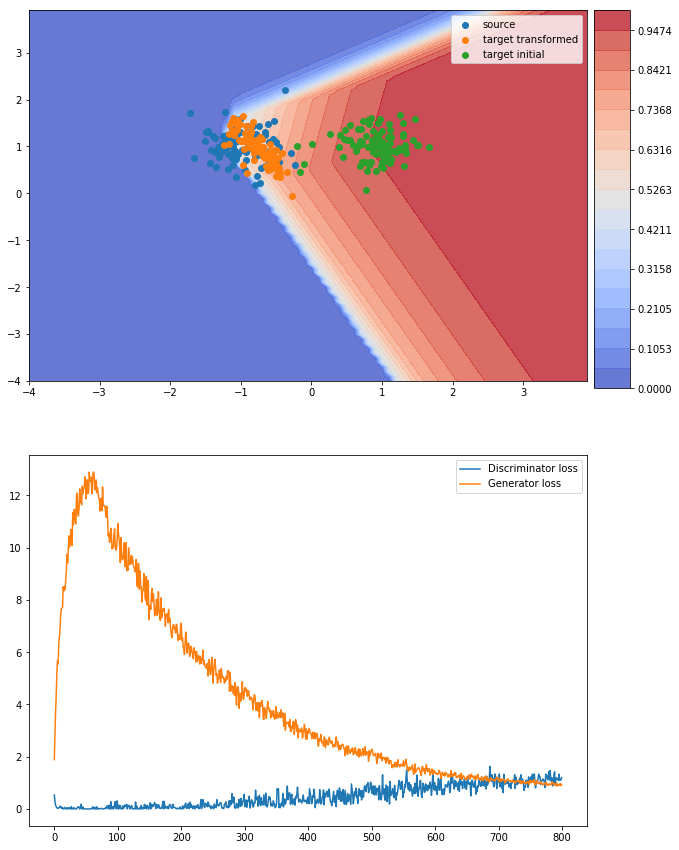

In [36]:
plt.rcParams['figure.figsize'] = (10, 15)
# plt.axes().set_aspect('equal', 'datalim')
# plt.axis([-3,3,-3,3])

x_min, x_max = -4, 4
y_min, y_max = -4, 4
h = .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

levels = np.linspace(0,1,20)
cm = plt.cm.coolwarm
Z = sess.run(D_source, feed_dict={S_input: np.c_[xx.ravel(), yy.ravel()]}).reshape(xx.shape)

f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[10, 10]})

cont = a0.contourf(xx, yy, 1-Z, levels, cmap=cm, alpha=.8)

a0.scatter(X_source[:,0], X_source[:,1], label="source")
a0.scatter(X_target_trans[:,0], X_target_trans[:,1], label="target transformed")
a0.scatter(X_target[:,0], X_target[:,1], label="target initial")

a0.legend()
cax = f.add_axes([0.91,0.53,0.05,0.35])
f.colorbar(cont, cax=cax, orientation="vertical")

a1.plot(D_loss_list, label="Discriminator loss")
a1.plot(T_loss_list, label="Generator loss")
a1.legend()

In [433]:
f.savefig("screenshots/D2-2-10-T1-2_v2.png")

In [203]:
sess.run(D_target, feed_dict={T_input: np.array([[0,0]])})

array([[ 0.5]], dtype=float32)

In [335]:
2*np.arange(len(D_loss_list)//2)

array([    0,     2,     4, ..., 10394, 10396, 10398])